# Bayesian time-difference-of-arrival positioning with pymc3

In this notebook we demonstrate how to carry out probabilistic time-difference-of-arrival (TDOA) positioning using `pymc3` and our `BayesianTDOAPositioner` class.

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bayes_positioner import BayesianTDOAPositioner

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


## Step 1: generate some test data
First we generate some test data to test our code with.

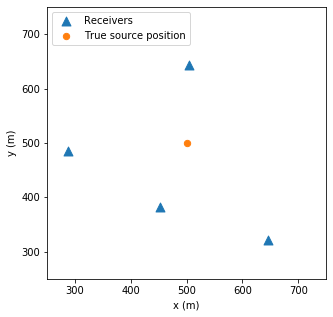

t_obs (ms): [-0.32348179 -0.38705054 -0.63469184 -0.71106496]


In [2]:
# generate some test data
N_STATIONS = 4

np.random.seed(1)
stations = np.random.randint(250,750, size=(N_STATIONS,2))# station positions (m)
x_true = np.array([500,500])# true source position (m)
v_true = 346.# speed of sound (m/s)
t1_true = 0.5*(np.sqrt(2)*500/346)# can be any constant, as long as it is within the uniform distribution prior on t1
d_true = np.linalg.norm(stations-x_true, axis=1)
t0_true = d_true/v_true# true time of flight values
t_obs = t0_true-t1_true# time difference of arrival values
np.random.seed(1)
t_obs = t_obs+0.05*np.random.randn(*t_obs.shape)# noisy observations


plt.figure(figsize=(5,5))
plt.scatter(stations[:,0], stations[:,1], marker="^", s=80, label="Receivers")
plt.scatter(x_true[0], x_true[1], s=40, label="True source position")
plt.legend(loc=2)
plt.xlim(250, 750)
plt.ylim(250, 750)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

print("t_obs (ms):", t_obs)

## Step 2: define a TDOA model in pymc3 and sample from its posterior
Next we use our `BayesianTDOAPositioner` to define a pymc3 TDOA forward model and sample from its posterior to estimate the location of the source.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1, v, x]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:16<00:00, 958.11draws/s] 


Percent divergent traces: 0.00 %
         mean      sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v     339.946  19.527  304.700  378.657      0.285    0.202    4696.0  4693.0   
x[0]  519.753  14.406  492.966  546.313      0.196    0.139    5404.0  5380.0   
x[1]  497.006  11.767  475.877  520.071      0.159    0.113    5451.0  5434.0   
t1      1.052   0.042    0.971    1.129      0.001    0.000    4640.0  4637.0   

      ess_bulk  ess_tail  r_hat  
v       4708.0    4357.0    1.0  
x[0]    5449.0    4664.0    1.0  
x[1]    5450.0    4766.0    1.0  
t1      4651.0    4288.0    1.0  


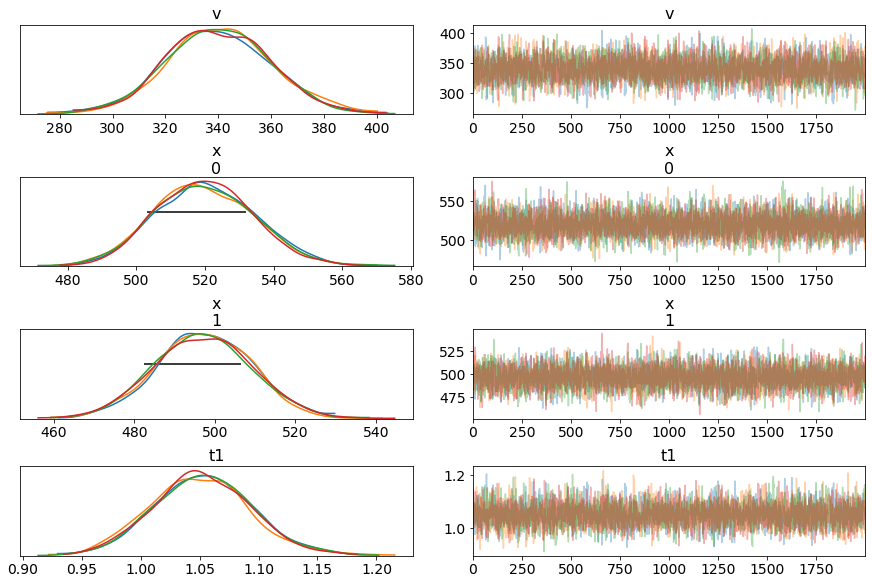

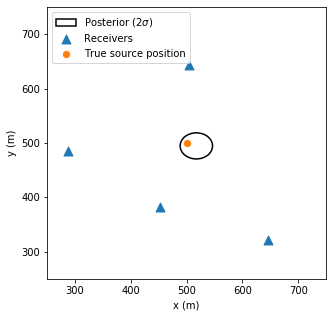

In [3]:
# sample
np.random.seed(1)
B = BayesianTDOAPositioner(# defines a pymc3 forward model
                 stations,
                 x_lim=1000,# maximum box size (m)
                 v_mu=346,# mean of velocity prior (m/s)
                 v_sd=20,# standard deviation of velocity prior (m/s)
                 t_sd=0.05)# standard deviation of observed values (s)

trace, summary, _, _ = B.sample(t_obs)# sample from the posterior

# analysis
mu, sd = B.fit_xy_posterior(trace)# this is a helper function to estimate the mean and standard deviation of the samples

# report
print(summary)

# trace plot
ax,ay = pm.traceplot(trace, compact=False)[1:3,0]
ax.hlines(0.6065*ax.get_ylim()[1], mu[0]-sd[0], mu[0]+sd[0])# add mu, sigma lines to x,y plots
ay.hlines(0.6065*ay.get_ylim()[1], mu[1]-sd[1], mu[1]+sd[1])
plt.savefig("figures/bayes_positioner_result1.jpg", bbox_inches='tight', pad_inches=0.01, dpi=300)

# local map
plt.figure(figsize=(5,5))
plt.scatter(stations[:,0], stations[:,1], marker="^", s=80, label="Receivers")
plt.scatter(x_true[0], x_true[1], s=40, label="True source position")
ell = matplotlib.patches.Ellipse(xy=(mu[0], mu[1]),
          width=4*sd[0], height=4*sd[1],
          angle=0., color='black', label="Posterior ($2\sigma$)", lw=1.5)
ell.set_facecolor('none')
plt.gca().add_patch(ell)
plt.legend(loc=2)
plt.xlim(250, 750)
plt.ylim(250, 750)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.savefig("figures/bayes_positioner_result2.jpg", bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()